# Introduction - A Prediction:
**The use of the DenseNet model for multiclassification of the conditions in the NIH chest x-ray dataset.**
This is a continuation from the analysis of this data [https://www.kaggle.com/code/naijaoracle/nih-chest-x-ray-dataset-analysis](http://)

![clinicians reviewing chest x-rays.png](attachment:7df5b1d7-00c6-4c8e-a287-4656736921cb.png)

## File loading

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.filterwarnings('ignore', category=FutureWarning) # Suppress warnings about future library updates

In [2]:
%%capture
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
#We load the datasets into pandas dataframes

try:
    df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv', delimiter=',')
except FileNotFoundError as e:
    print(f"Error: {e}")
    # Handle the error, e.g., provide a default dataframe or exit the program

# A basic overview of the NIH chest x-ray data.

We will use some exploratory functions to see what this data looks like.
head(), describe().

In [4]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [5]:
df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


And for the second dataframe.

## Data cleaning and preprocessing

In [6]:
column_list = df.columns.tolist()
print(column_list)

['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11']


In [7]:
# Split the 'Findings' column into separate conditions
df['Conditions'] = df['Finding Labels'].str.split('|')

# This will give you a new column 'Conditions' where each entry is a list of conditions

df['Num Conditions'] = df['Conditions'].apply(len)

df_exploded = df.explode('Conditions')

In [8]:
# Split the 'Finding Labels' column into separate conditions
df['Conditions'] = df['Finding Labels'].str.split('|')

# Convert the list of conditions to a string
df['Conditions'] = df['Conditions'].apply(lambda x: ' '.join(x))

# Create dummy variables for each condition
condition_dummies = df['Conditions'].str.get_dummies(sep=' ')

# Concatenate the original DataFrame with the dummy DataFrame
df = pd.concat([df, condition_dummies], axis=1)

From calling df.head() we can see that the conditions are listed in the column 'Finding Label' which we can extract.

In [9]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Finding,Hernia,Infiltration,Mass,No,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,1,0,0,0,1,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,1,0,0,0,0,0,0,0


Split the 'Finding Labels' colmumn into separate conditions.

In [10]:
# Select relevant columns
df = df[['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender']]

# Make sure the labels are of the string type
df['Finding Labels'] = df['Finding Labels'].astype(str)

# Split the labels into the different conditions
df['Finding Labels'] = df['Finding Labels'].str.split('|')

# The list of conditions
pathology_list = ['No Finding','Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

# Create new columns for each disease
def create_disease_columns(dataframe, pathology_list):
    for pathology in pathology_list:
        dataframe[pathology] = dataframe['Finding Labels'].apply(lambda x: int(pathology in x))
    return dataframe

# Call the function with the dataframe and pathology_list
df = create_disease_columns(df, pathology_list)

In [11]:
# Drop the 'Finding Labels' column
df = df.drop('Finding Labels', axis=1)

We can see that a majority of the patients are between the ages of 0 and 100. There are a few that are above 100 years old and  of those were above the current record of 122 years old. We can look deeper into this and make changes as there is a high chance that those are errors.

In [12]:
# Create a boolean mask for ages greater than 100
mask = df['Patient Age'] > 100

# Use the mask to filter the DataFrame
filtered_df = df[mask]

# Get the number of rows in the filtered DataFrame
num_persons = filtered_df.shape[0]

print(num_persons)

16


In [13]:
# Create a boolean mask for ages less than or equal to 100
mask = df['Patient Age'] <= 100

# Use the mask to filter the DataFrame
df = df[mask]

After removing the patients with ages above the current record of 122 years old, we can visualise the age distribution again.

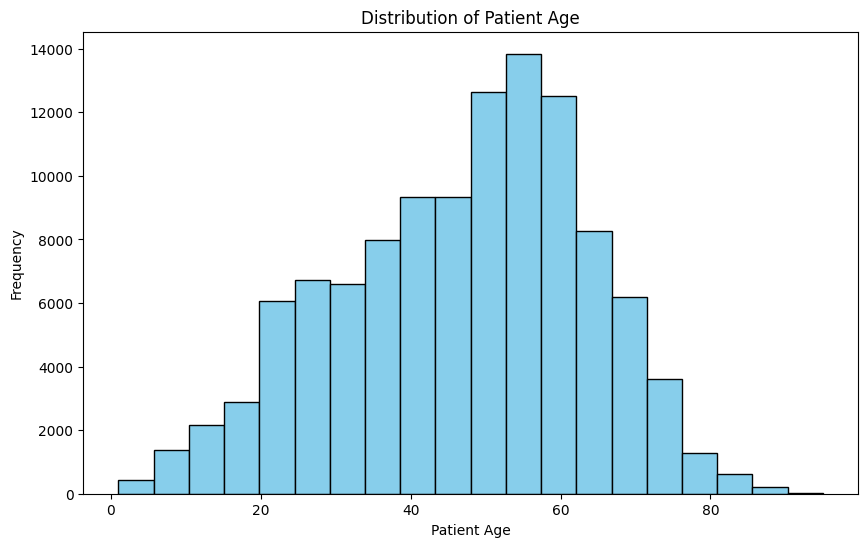

In [14]:
# Create a histogram of the 'Patient Age' column
plt.figure(figsize=(10,6))
plt.hist(df['Patient Age'], bins=20, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Patient Age')
plt.ylabel('Frequency')
plt.title('Distribution of Patient Age')

# Display the plot
plt.show()

In [15]:
# Loop through the conditions and print their sum total in the data
pathology_list = ['No Finding','Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

for condition in pathology_list:
    print(f"{condition}: {df[condition].sum()}")

No Finding: 60353
Cardiomegaly: 2776
Consolidation: 4667
Edema: 2302
Effusion: 13316
Emphysema: 2516
Fibrosis: 1686
Hernia: 227
Infiltration: 19891
Mass: 5779
Nodule: 6331
Pleural_Thickening: 3384
Pneumonia: 1430
Pneumothorax: 5301


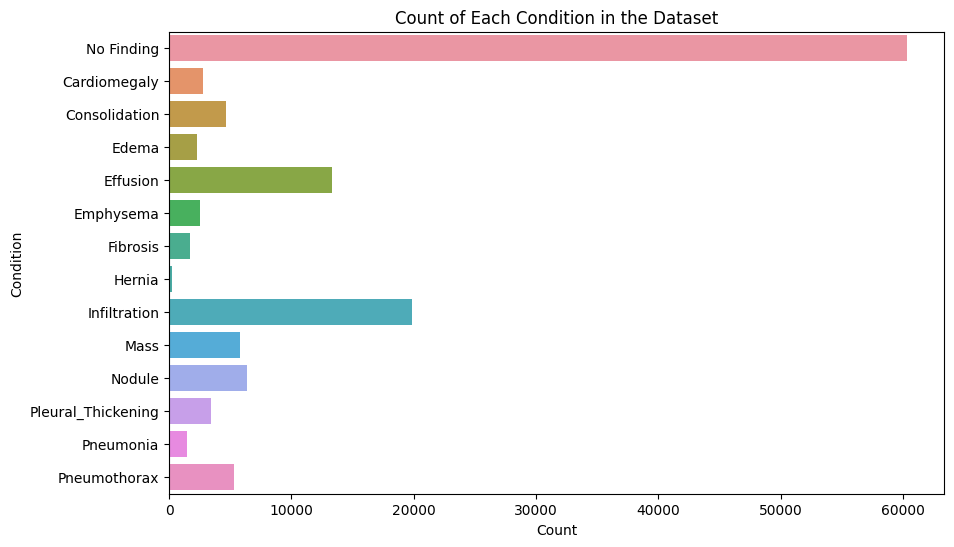

In [16]:
# Set the default palette
sns.set_palette('viridis')

# Create a list to store the counts of each condition
condition_counts = [df[pathology].sum() for pathology in pathology_list]

# Create a DataFrame from the condition counts
data = pd.DataFrame({
    'Condition': pathology_list,
    'Count': condition_counts
})

# Create a bar plot
plt.figure(figsize=(10,6))
sns.barplot(y='Condition', x='Count', data=data)

# Add labels and title
plt.xlabel('Count')
plt.ylabel('Condition')
plt.title('Count of Each Condition in the Dataset')

# Display the chart
plt.show()

## Chest x-rays with findings vs no findings.

We can see that approximately 54% of the chest x-rays in this dataset are labelled as having no findings, this can present challenges or learning opportunities depending on what we want to do with our data.
We may want to know what features differentiate those with no findings from those with findings.

For machine learning we may want to take measures to ensure having a large number of ‘No Finding’ images does not bias the model towards predicting ‘No Finding'.

In [17]:
# Create age groups
bins = list(range(0, 101, 10))  # Creates bins from 0 to 130 with a step of 10
labels = [f'{i}-{i+9}' for i in range(0, 100, 10)]  # Creates labels for these bins
df['Age Group'] = pd.cut(df['Patient Age'], bins=bins, labels=labels, right=False)

# Calculate % of total per age group
total_patients = df.shape[0]
df_total = df['Age Group'].value_counts().sort_index() / total_patients * 100

# Calculate % of no findings per age group
df_no_findings = df[df['No Finding'] == 1].groupby('Age Group').size() / df.groupby('Age Group').size() * 100

# Combine both series into a dataframe
age_analysis_df = pd.concat([df_total, df_no_findings], axis=1)
age_analysis_df.columns = ['% of Total', '% of No Findings']

# Print the dataframe
print(age_analysis_df)

           % of Total  % of No Findings
Age Group                              
0-9          1.251516         59.871703
10-19        4.835688         58.254935
20-29       11.416185         57.462103
30-39       14.551666         58.413535
40-49       19.384679         55.851088
50-59       24.446942         51.988616
60-69       17.191180         48.988169
70-79        5.923963         47.718717
80-89        0.940198         42.884250
90-99        0.057982         38.461538


In [18]:
# Calculate the sum of each pathology
pathology_sums = df[pathology_list].sum()

# Calculate the sum of all pathologies except 'No Finding'
other_pathologies_sum = pathology_sums.sum() - pathology_sums['No Finding']

print(f"No Finding: {df['No Finding'].sum()}")
print(f"Other conditions: {other_pathologies_sum}")
print(f"Total: {pathology_sums.sum()}")

No Finding: 60353
Other conditions: 69606
Total: 129959


In [19]:
import glob
# Load the images
root_folder = "/kaggle/input/data/"

# Use glob to get all PNG images from the subfolders
try:
    image_paths = glob.glob(os.path.join(root_folder, "images_*/images/*.png"))
except FileNotFoundError as e:
    print(f"Error: {e}")
    # Handle the error, e.g., provide default paths or exit the program

# Machine Learning Section

Now that we have had a look at the data we are working with, we can begin to build our model. Remember:
- PyTorch
- DenseNet
So we start by importing the necessary libraries and take it from there.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from imblearn.under_sampling import RandomUnderSampler
from PIL import Image
from tqdm import tqdm
import glob
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

2024-03-01 12:05:02.078792: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 12:05:02.078883: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 12:05:02.207671: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [21]:
%%capture

def create_image_path_series(directory):
    if not os.path.isdir(directory):
        raise FileNotFoundError(f"Directory '{directory}' not found.")

    image_paths = []
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            try:
                filepath = os.path.join(dirname, filename)
                if filename.endswith(('.jpg', '.png', '.jpeg')):
                    image_paths.append(filepath)
            except OSError as e:
                print(f"Error processing file '{filepath}': {e}")

    return pd.Series(image_paths, index=image_paths)

# Example usage:
directory = "/kaggle/input"

try:
    image_path_series = create_image_path_series(directory)
    print(image_path_series)
except (FileNotFoundError, ValueError) as e:
    print(e)

In [22]:
# Make a copy of the dataframe
df_coded = df.copy()

# Create a new column 'target'
# If 'No Finding' is 1 then target is 0 (no condition), else target is 1 (there is a condition)
df_coded['target'] = df_coded['No Finding'].apply(lambda x: 0 if x == 1 else 1)

In [23]:
df_coded.head()

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,No Finding,Cardiomegaly,Consolidation,Edema,Effusion,...,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Age Group,target
0,00000001_000.png,0,1,58,M,0,1,0,0,0,...,0,0,0,0,0,0,0,0,50-59,1
1,00000001_001.png,1,1,58,M,0,1,0,0,0,...,0,0,0,0,0,0,0,0,50-59,1
2,00000001_002.png,2,1,58,M,0,1,0,0,1,...,0,0,0,0,0,0,0,0,50-59,1
3,00000002_000.png,0,2,81,M,1,0,0,0,0,...,0,0,0,0,0,0,0,0,80-89,0
4,00000003_000.png,0,3,81,F,0,0,0,0,0,...,0,1,0,0,0,0,0,0,80-89,1


In [24]:
df_coded['Filepath'] = image_path_series[image_paths]

In [25]:
df_coded.head()

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,No Finding,Cardiomegaly,Consolidation,Edema,Effusion,...,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Age Group,target,Filepath
0,00000001_000.png,0,1,58,M,0,1,0,0,0,...,0,0,0,0,0,0,0,50-59,1,NaN
1,00000001_001.png,1,1,58,M,0,1,0,0,0,...,0,0,0,0,0,0,0,50-59,1,NaN
2,00000001_002.png,2,1,58,M,0,1,0,0,1,...,0,0,0,0,0,0,0,50-59,1,NaN
3,00000002_000.png,0,2,81,M,1,0,0,0,0,...,0,0,0,0,0,0,0,80-89,0,NaN
4,00000003_000.png,0,3,81,F,0,0,0,0,0,...,1,0,0,0,0,0,0,80-89,1,NaN


In [26]:
for index, row in tqdm(df_coded.iterrows(), total=len(df_coded)):
    filename = row['Image Index']
    for path_index, path in image_path_series.items():
        if filename in path:
            df_coded.loc[index, 'Filepath'] = path
            break

100%|██████████| 112104/112104 [44:40<00:00, 41.83it/s] 


In [27]:
df_coded.head()

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,No Finding,Cardiomegaly,Consolidation,Edema,Effusion,...,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Age Group,target,Filepath
0,00000001_000.png,0,1,58,M,0,1,0,0,0,...,0,0,0,0,0,0,0,50-59,1,/kaggle/input/data/images_001/images/00000001_...
1,00000001_001.png,1,1,58,M,0,1,0,0,0,...,0,0,0,0,0,0,0,50-59,1,/kaggle/input/data/images_001/images/00000001_...
2,00000001_002.png,2,1,58,M,0,1,0,0,1,...,0,0,0,0,0,0,0,50-59,1,/kaggle/input/data/images_001/images/00000001_...
3,00000002_000.png,0,2,81,M,1,0,0,0,0,...,0,0,0,0,0,0,0,80-89,0,/kaggle/input/data/images_001/images/00000002_...
4,00000003_000.png,0,3,81,F,0,0,0,0,0,...,1,0,0,0,0,0,0,80-89,1,/kaggle/input/data/images_001/images/00000003_...


In [28]:
# Separate 'No Finding' data
no_finding_df = df_coded[df_coded['No Finding'] == 1]

# Reduce 'No Finding' data to 40% of its current size
reduced_no_finding_df = no_finding_df.sample(frac=0.4, random_state=42)

# Get the rest of the data
other_data_df = df_coded[df_coded['No Finding'] == 0]

# Concatenate reduced 'No Finding' data with the rest of the data
reduced_df_coded = pd.concat([reduced_no_finding_df, other_data_df])

# Now split the reduced data into training and validation sets
train_df, val_df = train_test_split(reduced_df_coded, test_size=0.2, random_state=42)

**Training data and test data**
Our default using 80% of the data for training, the remaining 20% set aside for testing

In [29]:
# Convert 'Filepath' column values to strings
train_df['Filepath'] = train_df['Filepath'].astype(str)
val_df['Filepath'] = val_df['Filepath'].astype(str)

# Define data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="/kaggle/input/data/images",  # Directory containing the images
    x_col="Filepath",  # Column in dataframe containing image paths
    y_col=list(train_df.columns[5:-3]),  # Columns in dataframe containing labels
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',  # For multi-label classification
    subset='training'
)

# Flow validation images in batches using train_datagen generator
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory="/kaggle/input/data/images",  # Directory containing the images
    x_col="Filepath",  # Column in dataframe containing image paths
    y_col=list(val_df.columns[5:-3]),  # Columns in dataframe containing labels
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',  # For multi-label classification
    subset='validation'
)

Found 48571 validated image filenames.
Found 3035 validated image filenames.


In [30]:
# Convert labels to NumPy arrays
train_labels = train_df[list(train_df.columns[5:-3])].values.astype('float32')
val_labels = val_df[list(val_df.columns[5:-3])].values.astype('float32')

In [31]:
# Load the DenseNet121 model without the top (fully connected) layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base
base_model.trainable = False

# Create new model on top
model = Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(pathology_list), activation='sigmoid')
])

model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 14)                3598      
                                                                 
Total params: 7303502 (27.86 MB)
Trainable params: 265998 (1.01 MB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________


In [32]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

## Model training

In [33]:
num_epochs = 10

In [34]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Create an optimizer with a specific learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Create a learning rate scheduler
scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.01, patience=5)

# Define the checkpoint callback to save the best model
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                         monitor='val_loss',
                                                         save_best_only=True,
                                                         save_weights_only=True)
class TQDMCallback(tf.keras.callbacks.Callback):
    def __init__(self, total_epochs):
        self.total_epochs = total_epochs

    def on_train_begin(self, logs=None):
        self.epoch_pbar = tqdm(total=self.total_epochs, desc="Training")

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_pbar.update(1)
        self.epoch_pbar.set_postfix(logs)
        self.epoch_pbar.refresh()

total_epochs = num_epochs

# Create the TQDM callback instance
tqdm_callback = TQDMCallback(total_epochs)

class EvaluateCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        evaluation_results = self.model.evaluate(validation_generator, verbose=0)
        print("\nEvaluation results:")
        for metric_name, metric_value in zip(self.model.metrics_names, evaluation_results):
            print(f"{metric_name}: {metric_value}")

# Create an instance of the custom evaluation callback
evaluate_callback = EvaluateCallback()

with tf.device('/GPU:0'):
    # Compile the model with the optimizer
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Convert labels to NumPy arrays
    train_labels = train_df[list(train_df.columns[5:-3])].values
    val_labels = val_df[list(val_df.columns[5:-3])].values

    # Train the model with the specified callbacks
    history = model.fit(
        train_generator,
        steps_per_epoch=int(train_generator.samples // train_generator.batch_size),
        epochs=num_epochs,
        validation_data=validation_generator,
        validation_steps=int(validation_generator.samples // validation_generator.batch_size),
        callbacks=[tqdm_callback, checkpoint_callback, evaluate_callback, early_stopping, scheduler]
    )

    # Evaluate the model on the entire validation dataset
    evaluation_results = model.evaluate(validation_generator, verbose=0)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


I0000 00:00:1709297562.499799     130 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1517/1517 [==============================] - ETA: 0s - loss: 0.2494 - accuracy: 0.3633

Training:  10%|█         | 1/10 [29:05<4:21:45, 1745.05s/it, loss=0.249, accuracy=0.363, val_loss=0.241, val_accuracy=0.373]


Evaluation results:
loss: 0.24058429896831512
accuracy: 0.37199342250823975
1517/1517 [==============================] - 1816s 1s/step - loss: 0.2494 - accuracy: 0.3633 - val_loss: 0.2411 - val_accuracy: 0.3730 - lr: 1.0000e-04
Epoch 2/10
1517/1517 [==============================] - ETA: 0s - loss: 0.2383 - accuracy: 0.3843

Training:  20%|██        | 2/10 [50:45<3:17:47, 1483.44s/it, loss=0.238, accuracy=0.384, val_loss=0.234, val_accuracy=0.401]


Evaluation results:
loss: 0.2353162318468094
accuracy: 0.40032950043678284
1517/1517 [==============================] - 1300s 857ms/step - loss: 0.2383 - accuracy: 0.3843 - val_loss: 0.2343 - val_accuracy: 0.4013 - lr: 1.0000e-04
Epoch 3/10
1517/1517 [==============================] - ETA: 0s - loss: 0.2361 - accuracy: 0.3865

Training:  30%|███       | 3/10 [1:12:20<2:43:03, 1397.58s/it, loss=0.236, accuracy=0.386, val_loss=0.234, val_accuracy=0.391]


Evaluation results:
loss: 0.23299619555473328
accuracy: 0.3884678781032562
1517/1517 [==============================] - 1295s 854ms/step - loss: 0.2361 - accuracy: 0.3865 - val_loss: 0.2343 - val_accuracy: 0.3913 - lr: 1.0000e-04
Epoch 4/10
1517/1517 [==============================] - ETA: 0s - loss: 0.2348 - accuracy: 0.3912

Training:  40%|████      | 4/10 [1:33:55<2:15:40, 1356.78s/it, loss=0.235, accuracy=0.391, val_loss=0.234, val_accuracy=0.391]


Evaluation results:
loss: 0.2328415960073471
accuracy: 0.39176276326179504
1517/1517 [==============================] - 1294s 853ms/step - loss: 0.2348 - accuracy: 0.3912 - val_loss: 0.2337 - val_accuracy: 0.3913 - lr: 1.0000e-04
Epoch 5/10
1517/1517 [==============================] - ETA: 0s - loss: 0.2338 - accuracy: 0.3918

Training:  50%|█████     | 5/10 [1:55:27<1:51:08, 1333.61s/it, loss=0.234, accuracy=0.392, val_loss=0.233, val_accuracy=0.401]


Evaluation results:
loss: 0.23311316967010498
accuracy: 0.39835256338119507
1517/1517 [==============================] - 1292s 852ms/step - loss: 0.2338 - accuracy: 0.3918 - val_loss: 0.2327 - val_accuracy: 0.4009 - lr: 1.0000e-04
Epoch 6/10
1517/1517 [==============================] - ETA: 0s - loss: 0.2330 - accuracy: 0.3941

Training:  60%|██████    | 6/10 [2:17:04<1:28:04, 1321.22s/it, loss=0.233, accuracy=0.394, val_loss=0.231, val_accuracy=0.395]


Evaluation results:
loss: 0.23158180713653564
accuracy: 0.39341020584106445
1517/1517 [==============================] - 1298s 856ms/step - loss: 0.2330 - accuracy: 0.3941 - val_loss: 0.2313 - val_accuracy: 0.3953 - lr: 1.0000e-04
Epoch 7/10
1517/1517 [==============================] - ETA: 0s - loss: 0.2329 - accuracy: 0.3937

Training:  70%|███████   | 7/10 [2:38:48<1:05:46, 1315.53s/it, loss=0.233, accuracy=0.394, val_loss=0.232, val_accuracy=0.393]


Evaluation results:
loss: 0.23104573786258698
accuracy: 0.39769357442855835
1517/1517 [==============================] - 1302s 858ms/step - loss: 0.2329 - accuracy: 0.3937 - val_loss: 0.2321 - val_accuracy: 0.3926 - lr: 1.0000e-04
Epoch 8/10
1517/1517 [==============================] - ETA: 0s - loss: 0.2321 - accuracy: 0.3929

Training:  80%|████████  | 8/10 [3:00:14<43:32, 1306.23s/it, loss=0.232, accuracy=0.393, val_loss=0.232, val_accuracy=0.412]  


Evaluation results:
loss: 0.23188398778438568
accuracy: 0.4135090708732605
1517/1517 [==============================] - 1286s 848ms/step - loss: 0.2321 - accuracy: 0.3929 - val_loss: 0.2318 - val_accuracy: 0.4122 - lr: 1.0000e-04
Epoch 9/10
1517/1517 [==============================] - ETA: 0s - loss: 0.2316 - accuracy: 0.3982

Training:  90%|█████████ | 9/10 [3:21:46<21:41, 1301.79s/it, loss=0.232, accuracy=0.398, val_loss=0.23, val_accuracy=0.401] 


Evaluation results:
loss: 0.23055827617645264
accuracy: 0.3980230689048767
1517/1517 [==============================] - 1292s 852ms/step - loss: 0.2316 - accuracy: 0.3982 - val_loss: 0.2305 - val_accuracy: 0.4013 - lr: 1.0000e-04
Epoch 10/10
1517/1517 [==============================] - ETA: 0s - loss: 0.2313 - accuracy: 0.3976

Training: 100%|██████████| 10/10 [3:43:21<00:00, 1299.64s/it, loss=0.231, accuracy=0.398, val_loss=0.23, val_accuracy=0.406]


Evaluation results:
loss: 0.23089277744293213
accuracy: 0.4059308171272278
1517/1517 [==============================] - 1295s 854ms/step - loss: 0.2313 - accuracy: 0.3976 - val_loss: 0.2305 - val_accuracy: 0.4056 - lr: 1.0000e-04


# Performance visualisation

To visualise the performance of our model's performance based on our metrics.

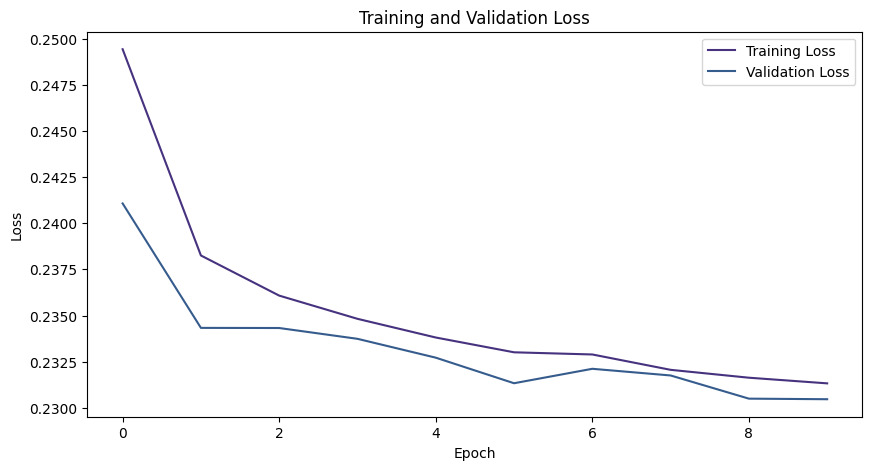

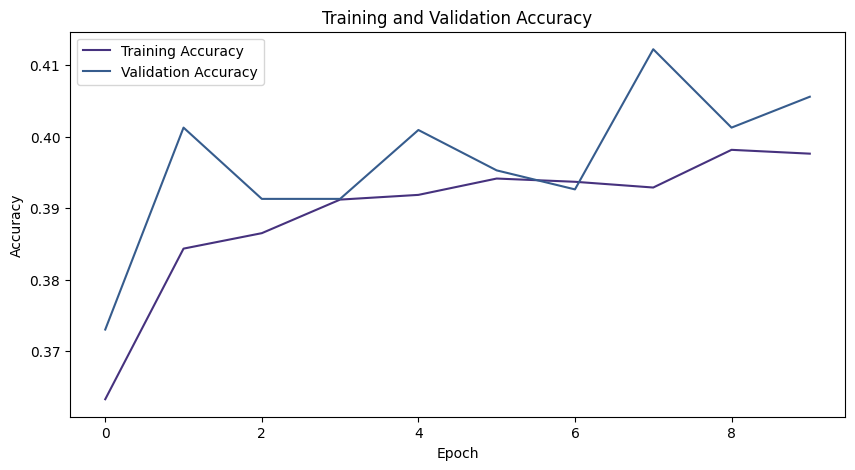

In [36]:
# Import visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [38]:
plt.savefig("loss_plot.png")
plt.savefig("accuracy_plot.png")

<Figure size 640x480 with 0 Axes>